# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [11]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
scores = final['Score']

# Split the Data Set into train and test

In [14]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================

warnings.filterwarnings("ignore") 
# split the data set into train and test
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(final['Text'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_tr = y_tr.values

#sampling data
train_indices = np.random.choice(len(X_tr),70000,replace=False)
test_indices = np.random.choice(len(X_test),30000,replace=False)
X_tr = X_tr[train_indices]
y_tr = y_tr[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

#Converting text to tfidf vector(BOW)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector = final_tf_idf.transform(X_tr)
X_test_vector = final_tf_idf.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Column Standardization

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector)
X_tr_vector = scaler.transform(X_tr_vector)
X_test_vector =scaler.transform(X_test_vector)

# Find Optimal Lamda using GridSearchCV

In [18]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore")
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8907333333333334


# l2 Regularizer

             precision    recall  f1-score   support

   negative       0.95      0.33      0.49      4755
   positive       0.89      1.00      0.94     25245

avg / total       0.90      0.89      0.87     30000

Coefficient of each feature: [[-0.00520707  0.0014236   0.00022962 ...  0.00074391  0.00235441
   0.00235441]]
Training accuracy: 1.0
Test accuracy: 0.8907333333333334


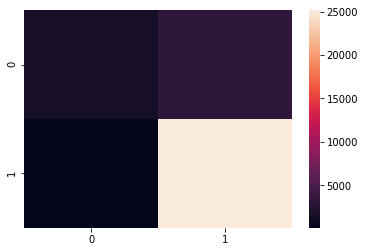

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=10000,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
pre_weights =classifier.coef_
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
pre_weights =classifier.coef_
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# l1 Regularizer

             precision    recall  f1-score   support

   negative       0.79      0.42      0.55      4755
   positive       0.90      0.98      0.94     25245

avg / total       0.88      0.89      0.88     30000

Coefficient of each feature: [[ 0.01296342  0.00053513 -0.00148345 ...  0.00348667  0.00093151
   0.00720002]]
Training accuracy: 1.0
Test accuracy: 0.8904


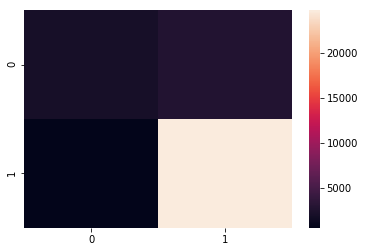

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=10000,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
pre_weights =classifier.coef_
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
pre_weights =classifier.coef_
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# Find Optimal Lamda using RandomSearchCV

In [22]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 


tuned_parameters = {"C": stats.uniform(10**-4, 10**4)}
#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=2078.4790554231986, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8952333333333333


# L2 Regularizer

             precision    recall  f1-score   support

   negative       0.94      0.36      0.52      4755
   positive       0.89      1.00      0.94     25245

avg / total       0.90      0.90      0.88     30000

Coefficient of each feature: [[-4.79075747e-03  1.25396354e-03  7.01925393e-05 ...  3.81880716e-04
   2.21987255e-03  2.21987255e-03]]
Training accuracy: 1.0
Test accuracy: 0.8952333333333333


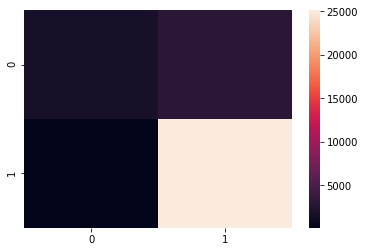

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=2078.4790554231986,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
pre_weights =classifier.coef_
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
pre_weights =classifier.coef_
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# L1 Regularizer

             precision    recall  f1-score   support

   negative       0.82      0.43      0.56      4755
   positive       0.90      0.98      0.94     25245

avg / total       0.89      0.89      0.88     30000

Coefficient of each feature: [[ 9.49212841e-04  2.76083385e-04  0.00000000e+00 ... -8.41000881e-05
   0.00000000e+00  4.22122480e-03]]
Training accuracy: 1.0
Test accuracy: 0.8946333333333333


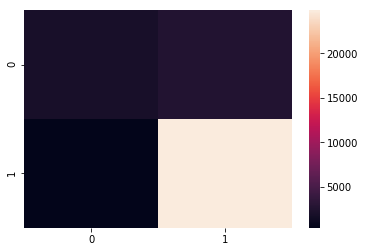

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
classifier = LogisticRegression(C=2078.4790554231986,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4755
   positive       0.84      1.00      0.91     25245

avg / total       0.71      0.84      0.77     30000

Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 0.8423142857142857
Test accuracy: 0.8415
No of Non-zero elements: 2


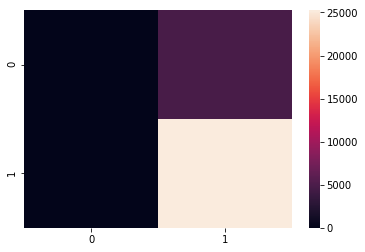

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
C_values = []
non_zero_values = []
test_accuracy =[]
classifier = LogisticRegression(C=0.0001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.0001)

             precision    recall  f1-score   support

   negative       0.91      0.26      0.41      4755
   positive       0.88      1.00      0.93     25245

avg / total       0.88      0.88      0.85     30000

Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 0.8797428571428572
Test accuracy: 0.8787666666666667
No of Non-zero elements: 136


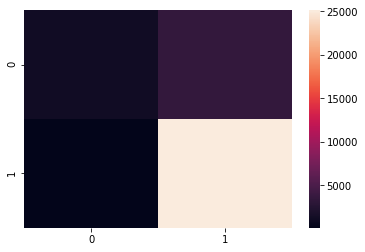

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
classifier = LogisticRegression(C=0.001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.001)

             precision    recall  f1-score   support

   negative       0.87      0.65      0.74      4755
   positive       0.94      0.98      0.96     25245

avg / total       0.93      0.93      0.92     30000

Coefficient of each feature: [[-0.01325943  0.          0.         ...  0.          0.
   0.        ]]
Training accuracy: 0.9997571428571429
Test accuracy: 0.9279333333333334
No of Non-zero elements: 22431


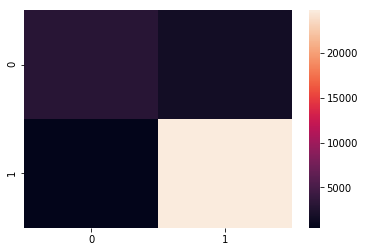

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
classifier = LogisticRegression(C=0.01,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.01)

             precision    recall  f1-score   support

   negative       0.85      0.65      0.74      4755
   positive       0.94      0.98      0.96     25245

avg / total       0.92      0.93      0.92     30000

Coefficient of each feature: [[-0.00740295  0.          0.         ...  0.          0.
   0.        ]]
Training accuracy: 1.0
Test accuracy: 0.9263666666666667
No of Non-zero elements: 38589


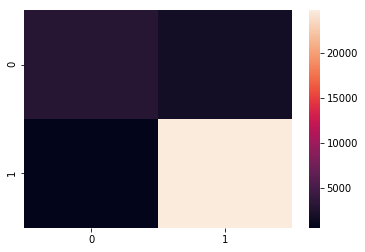

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.1)

             precision    recall  f1-score   support

   negative       0.87      0.64      0.74      4755
   positive       0.94      0.98      0.96     25245

avg / total       0.92      0.93      0.92     30000

Coefficient of each feature: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.67306193e-05]]
Training accuracy: 1.0
Test accuracy: 0.9274666666666667
No of Non-zero elements: 50944


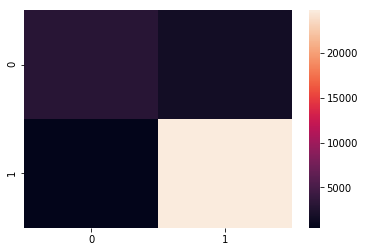

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(1)

             precision    recall  f1-score   support

   negative       0.90      0.57      0.69      4755
   positive       0.92      0.99      0.95     25245

avg / total       0.92      0.92      0.91     30000

Coefficient of each feature: [[0.         0.001617   0.         ... 0.         0.         0.00025915]]
Training accuracy: 1.0
Test accuracy: 0.9211
No of Non-zero elements: 100557


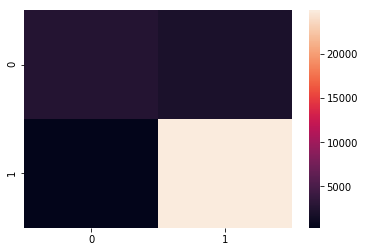

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=10,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(10)

             precision    recall  f1-score   support

   negative       0.89      0.48      0.63      4755
   positive       0.91      0.99      0.95     25245

avg / total       0.91      0.91      0.90     30000

Coefficient of each feature: [[0.         0.         0.         ... 0.         0.         0.00085671]]
Training accuracy: 1.0
Test accuracy: 0.9087333333333333
No of Non-zero elements: 252270


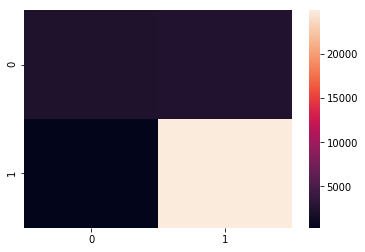

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=100,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(100)

# C vs Sparsity

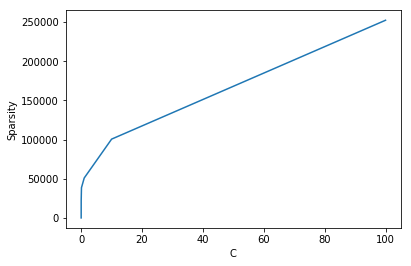

In [34]:
plt.plot(C_values, non_zero_values)
plt.xlabel('C')
plt.ylabel('Sparsity')
plt.show()

# C vs Test Accuracy

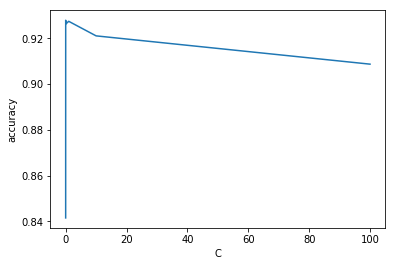

In [35]:
plt.plot(C_values, test_accuracy)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()

# Checking Multicollinearity

In [36]:
#adding epsilon to train data for multicollinearity check
import scipy.stats
X_train = X_tr_vector.copy()
X_train.todense()
print(scipy.stats.norm.rvs(loc=0, scale=0.01))
X_train.data += scipy.stats.norm.rvs(loc=0, scale=0.01)

0.014245923605978374


             precision    recall  f1-score   support

   negative       0.95      0.26      0.41      4755
   positive       0.88      1.00      0.93     25245

avg / total       0.89      0.88      0.85     30000

Coefficient of each feature: [[-0.00129929  0.00036694  0.00014389 ...  0.00024704  0.00059258
   0.00059258]]
Training accuracy: 1.0
Test accuracy: 0.8807333333333334


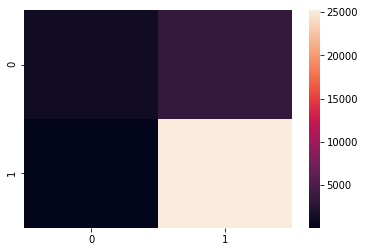

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.0001,penalty='l2')
classifier.fit(X_train, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
post_weights = classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_train, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

In [38]:
pre_weights

array([[-4.79075747e-03,  1.25396354e-03,  7.01925393e-05, ...,
         3.81880716e-04,  2.21987255e-03,  2.21987255e-03]])

In [39]:
post_weights

array([[-0.00129929,  0.00036694,  0.00014389, ...,  0.00024704,
         0.00059258,  0.00059258]])

In [40]:
difference =[]
for i in post_weights:
    difference.append(np.abs(pre_weights-post_weights))

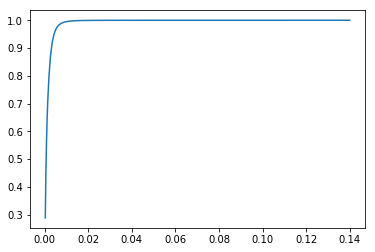

In [41]:
counts, bin_edges = np.histogram(difference, bins=500, density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)

# Conclusion

In [42]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['CV Method', 'Optimal C','regularizer','Train Error','Test Error']
t.add_row(["GridSearchCV","10000","l2","0","0.10926666666"])
t.add_row(["GridSearchCV","10000","l1","0","0.1096"])
t.add_row(["RandomSearchCV","2078.4790554231986","l2","0","0.10476666666"])
t.add_row(["RandomSearchCV","2078.4790554231986","l1","0","0.10536666666"])
print(t)
print("**C Vs Sparsity with l1 regularizer**")
t1 = PrettyTable()
t1.field_names = ['C', 'Sparsity']
t1.add_row(["0.0001","2"])
t1.add_row(["0.001","136"])
t1.add_row(["0.01","22431"])
t1.add_row(["0.1","38589"])
t1.add_row(["1","50944"])
t1.add_row(["10","100557"])
t1.add_row(["100","252270"])
print(t1)
print("->->Features are not multicollnear hence |wj| can be taken for Feature Importance.")

+----------------+--------------------+-------------+-------------+---------------+
|   CV Method    |     Optimal C      | regularizer | Train Error |   Test Error  |
+----------------+--------------------+-------------+-------------+---------------+
|  GridSearchCV  |       10000        |      l2     |      0      | 0.10926666666 |
|  GridSearchCV  |       10000        |      l1     |      0      |     0.1096    |
| RandomSearchCV | 2078.4790554231986 |      l2     |      0      | 0.10476666666 |
| RandomSearchCV | 2078.4790554231986 |      l1     |      0      | 0.10536666666 |
+----------------+--------------------+-------------+-------------+---------------+
**C Vs Sparsity with l1 regularizer**
+--------+----------+
|   C    | Sparsity |
+--------+----------+
| 0.0001 |    2     |
| 0.001  |   136    |
|  0.01  |  22431   |
|  0.1   |  38589   |
|   1    |  50944   |
|   10   |  100557  |
|  100   |  252270  |
+--------+----------+
->There is no multicollinearity
